In [1]:
import torch
from transformers import T5ForConditionalGeneration, T5TokenizerFast
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
!nvidia-smi

Sun Jan 12 01:42:00 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# GPU 메모리 캐시 초기화
torch.cuda.empty_cache()

# 키워드 생성 및 감정 라벨 동시 학습 (데이터 전처리 완료)

In [2]:
# Define the dataset class for review to keyword+sentiment generation
class ReviewWithSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        """
        Dataset class for handling review-to-keyword+sentiment data.

        Args:
            dataframe (pd.DataFrame): DataFrame with Review and Keywords_Sentiments.
            tokenizer (T5Tokenizer): Tokenizer for processing text data.
            max_len (int): Maximum token length for input and target sequences.
        """
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]

        # 프롬프트 추가
        input_text = (
            "You are an assistant responsible for extracting meaningful keywords from reviews and assigning a sentiment label (positive/negative) to each keyword. "
            "The meaningful keywords should be related to aspects such as taste, service, ambiance, cleanliness, and cost-effectiveness. "
            "You should extract 3-5 key phrases from the review, but additional phrases can be included if necessary. "
            "The output format should be as follows: keyword1(sentiment1), keyword2(sentiment2), ... "
            "Review: " + row['Review']
        )
        target_text = row['Keywords_Sentiments']  # Combined keyword+sentiment

        # Tokenize input and target text
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        targets = self.tokenizer(
            target_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': targets['input_ids'].squeeze(0),
        }


In [ ]:
# Load and preprocess the dataset
# file_path = "/content/Transformed_Reviews_with_Sentiments.csv"  # Dataset path
# data = pd.read_csv(file_path)
# # data.columns = [col.strip() for col in data.columns]  # Strip any whitespace

In [3]:
naver = pd.read_csv('/content/Transformed_Naver_Reviews_with_Sentiments.csv')
kakao = pd.read_csv('/content/Transformed_Kakao_Reviews_with_Sentiments.csv')
data = pd.concat([naver, kakao], ignore_index=True)

In [ ]:
data

,StoreName,Review,Keywords_Sentiments
0,153스트리트,153베이컨버거와 더블클래식버거 감자튀김 먹었어요. 둘다 수제버거만의 매력이 듬뿍 ...,"수제버거(Positive), 패티(Positive), 빵(Positive), 야채(..."
1,153스트리트,153스트리트의 특징은 계란후라이!! 패티도 촉촉하지만 반숙계란으로 촉촉함이 추가되...,"계란후라이(Positive), 패티 촉촉함(Positive), 패티 두툼함(Posi..."
2,153스트리트,2층에위치해 있고 창문쪽 바석에서 밖보며 먹는것도 좋을 것 같아요! 홀도 꽤 넓고 ...,"창문쪽 바석에서 밖보며 먹는 것(Positive), 홀 꽤 넓음(Positive),..."
3,153스트리트,BBC버거 치즈가 흘러내려 먹음직해서 픽 했는데 역시나 짱이요,"치즈가 흘러내려 먹음직한(Positive), 픽 했는데 짱이요(Positive)"
4,153스트리트,가게가 예뻐요!!,가게가 예뻐요(Positive)
...,...,...,...
9127,회기왕족발보쌈,진짜 싸가지없음 젊은사람 소규모면 무시하는듯.. 장사잘되면 단가? 리뷰 잘 안남기는...,"싸가지없음(Negative), 젊은사람 소규모면 무시(Negative), 장사잘되면..."
9128,회기왕족발보쌈,진짜너무합니다사장님장사 이렇게하시면너무하죠먹구있는데걸레질하시고십분전에 나가라하시고이...,"청소 중 식사(Negative), 불친절(Negative), 운영 시간(Negative)"
9129,회기왕족발보쌈,쫄깃한 족발이 맛있습니다. 잡내도 안나서 맛있게 먹었던 것 같아요.하지만 내부가 너...,"쫄깃한 족발(Positive), 잡내도 안남(Positive), 내부 시끄러움(Ne..."
9130,회기왕족발보쌈,최고다,최고다(Positive)


In [ ]:
data.to_csv('/content/Transformed_Reviews_with_Sentiments.csv', index=False, encoding='utf-8-sig')

## 데이터셋 split& 모델 준비

In [4]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
train_data.to_csv('/content/train_data.csv', index=False, encoding='utf-8-sig')
val_data.to_csv('/content/valid_data.csv', index=False, encoding='utf-8-sig')

In [ ]:
# Define tokenizer and model
model_name = "paust/pko-t5-base"  # Pretrained Korean T5 model
tokenizer = T5TokenizerFast.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.90M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

## 프롬프트 + 리뷰 토큰 길이 확인

In [ ]:
import numpy as np

In [ ]:
# 리뷰 데이터의 토큰 길이 계산
token_lens = [len(tokenizer.encode(text)) for text in train_data["Review"]]

print(f"평균 길이: {sum(token_lens) / len(token_lens):.2f}")
print(f"최대 길이: {max(token_lens)}")

평균 길이: 42.62
최대 길이: 1217


In [ ]:
# 4분위수 계산
quartiles = np.percentile(token_lens, [25, 50, 75, 100])  # 25%, 50%, 75%, 최대값
quartile_results = {
    "1st Quartile (25%)": quartiles[0],
    "Median (50%)": quartiles[1],
    "3rd Quartile (75%)": quartiles[2],
    "Maximum": quartiles[3],
}

quartile_results

{'1st Quartile (25%)': 14.0,
 'Median (50%)': 28.0,
 '3rd Quartile (75%)': 53.0,
 'Maximum': 1217.0}

In [ ]:
prompt_example = (
    "You are an assistant responsible for extracting meaningful keywords from reviews and assigning a sentiment label (positive/negative) to each keyword. "
    "The meaningful keywords should be related to aspects such as taste, service, ambiance, cleanliness, and cost-effectiveness. "
    "You should extract 3-5 key phrases from the review, but additional phrases can be included if necessary. "
    "The output format should be as follows: keyword1(sentiment1), keyword2(sentiment2), ... "
    "Review: "
)

# 프롬프트 토큰 길이 계산
prompt_token_length = len(tokenizer.encode(prompt_example))
print("Prompt Token Length:", prompt_token_length)

Prompt Token Length: 270


## 데이터셋 준비, 모델 학습

In [ ]:
# Prepare the datasets
max_len = 350
batch_size = 16

train_dataset = ReviewWithSentimentDataset(train_data, tokenizer, max_len)
val_dataset = ReviewWithSentimentDataset(val_data, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load the model
model = T5ForConditionalGeneration.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(50358, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50358, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
# Training function
def train_model(model, dataloader, val_loader, optimizer, device, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        step = 0
        for batch in dataloader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            step += 1

            # Print loss every 20 steps
            if step % 20 == 0:
                print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.item():.4f}")

            # Print generated text every 100 steps
            if step % 100 == 0:
                model.eval()
                with torch.no_grad():
                    sample_input_ids = batch['input_ids'][0].unsqueeze(0).to(device)
                    sample_attention_mask = batch['attention_mask'][0].unsqueeze(0).to(device)
                    generated_output = model.generate(
                        input_ids=sample_input_ids,
                        attention_mask=sample_attention_mask,
                        max_length=128,
                        num_beams=5,
                        early_stopping=True
                    )
                    decoded_output = tokenizer.decode(generated_output[0], skip_special_tokens=True)
                    print(f"Step {step}: Generated Output: {decoded_output}")
                model.train()

        print(f"Epoch {epoch+1}, Training Loss: {total_loss / len(dataloader):.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                val_loss += outputs.loss.item()
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader):.4f}")
        model.train()


In [ ]:
# Train the model
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=3)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1, Step 20, Loss: 14.1663
Epoch 1, Step 40, Loss: 3.7331
Epoch 1, Step 60, Loss: 2.0811
Epoch 1, Step 80, Loss: 0.9405
Epoch 1, Step 100, Loss: 0.3978
Step 100: Generated Output: 마이스터(Positive), 커리(Positive)
Epoch 1, Step 120, Loss: 0.2593
Epoch 1, Step 140, Loss: 0.1669
Epoch 1, Step 160, Loss: 0.1466
Epoch 1, Step 180, Loss: 0.1166
Epoch 1, Step 200, Loss: 0.1017
Step 200: Generated Output: 예약(Positive), 인스타감성(Positive)
Epoch 1, Step 220, Loss: 0.0979
Epoch 1, Step 240, Loss: 0.0806
Epoch 1, Step 260, Loss: 0.0892
Epoch 1, Step 280, Loss: 0.0720
Epoch 1, Step 300, Loss: 0.0604
Step 300: Generated Output: 굿(Positive), 맛잇어요(Positive)
Epoch 1, Step 320, Loss: 0.0912
Epoch 1, Step 340, Loss: 0.0773
Epoch 1, Step 360, Loss: 0.0546
Epoch 1, Step 380, Loss: 0.0827
Epoch 1, Step 400, Loss: 0.0679
Step 400: Generated Output: 계란말이(Positive), 김찌(Positive)
Epoch 1, Step 420, Loss: 0.0555
Epoch 1, Step 440, Loss: 0.0769
Epoch 1, Training Loss: 1.4348
Epoch 1, Validation Loss: 0.0499
Epoch 2

In [ ]:
# Save the fine-tuned model
output_dir = "./t5_fine_tuned_keywords_sentiments2"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

Model saved to ./t5_fine_tuned_keywords_sentiments2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# google drive에 학습 완료된 모델 저장
# 모델 저장 경로 설정
drive_output_dir = '/content/drive/MyDrive/t5_fine_tuned_keywords_sentiments2'

# 모델 복사
!cp -r ./t5_fine_tuned_keywords_sentiments2/ $drive_output_dir

print(f"Model saved to Google Drive at {drive_output_dir}")

Model saved to Google Drive at /content/drive/MyDrive/t5_fine_tuned_keywords_sentiments2


# 모델 성능 테스트

In [ ]:
#!pip install nltk
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=378a19c723071179e9c32d99742ab810b36dac64885bea8caaeb244c962f415a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 데이터셋 로드
file_path = '/content/Transformed_Reviews_with_Sentiments.csv'  # 데이터셋 파일 경로
data = pd.read_csv(file_path)

# 데이터 확인
print(data.head())

  StoreName                                             Review  \
0   153스트리트  153베이컨버거와 더블클래식버거 감자튀김 먹었어요. 둘다 수제버거만의 매력이 듬뿍 ...   
1   153스트리트  153스트리트의 특징은 계란후라이!! 패티도 촉촉하지만 반숙계란으로 촉촉함이 추가되...   
2   153스트리트  2층에위치해 있고 창문쪽 바석에서 밖보며 먹는것도 좋을 것 같아요! 홀도 꽤 넓고 ...   
3   153스트리트                 BBC버거 치즈가 흘러내려 먹음직해서 픽 했는데 역시나 짱이요   
4   153스트리트                                          가게가 예뻐요!!   

                                 Keywords_Sentiments  
0  수제버거(Positive), 패티(Positive), 빵(Positive), 야채(...  
1  계란후라이(Positive), 패티 촉촉함(Positive), 패티 두툼함(Posi...  
2  창문쪽 바석에서 밖보며 먹는 것(Positive), 홀 꽤 넓음(Positive),...  
3       치즈가 흘러내려 먹음직한(Positive), 픽 했는데 짱이요(Positive)  
4                                  가게가 예뻐요(Positive)  


In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 나누기
train_data, eval_data = train_test_split(
    data,
    test_size=0.2,  # 평가 데이터 비율 (20%)
    random_state=42  # 재현성을 위한 시드 값
)

print(f"Train dataset size: {len(train_data)}")
print(f"Eval dataset size: {len(eval_data)}")

Train dataset size: 7305
Eval dataset size: 1827


In [ ]:
df10 = eval_data.head(10) # 테스트 데이터셋 10개만 추출

In [ ]:
df10

,StoreName,Review,Keywords_Sentiments
4043,을밀대 평양냉면,운 좋게 웨이팅 없이 먹을 수 있었어요!평냉 잘 먹고 갑니다👍,"웨이팅 없이(Positive), 평냉(Positive)"
3573,안녕유부,처음 오는 곳이기도 하고 친한 동생이 추천해준 집인데 정말 맛있고 가격도 적당해서 ...,"맛있고(Positive), 가격도 적당해서(Positive), 혼밥하러 오기 좋은 ..."
4505,정육면체 신촌점,아이가 검색해서 가고 싶다고 해서 들렀는데 더운날 30분정도 대기해도 본인이 선택한...,"기다리더라구요(Positive), 음식이 기대되는지(Positive), 불평없이 즐..."
5381,파치,매번 단체로 오기에 좋은 곳이에요 치킨 파스타 다 맛있어요❤️,"단체로 오기 좋은 곳(Positive), 치킨(Positive), 파스타(Posit..."
2881,성화금탕마라탕.튀김꼬치,진짜 맛있어요. 고기나 고수 따로 추가가 아니라 야채랑 똑같이 담을 수 있어서 가성...,"맛있어요(Positive), 가성비 좋아요(Positive), 양도 많아요(Posi..."
4701,쭈꾸미블루스 신촌본점,친구들이랑 오랜만에 만났는데 신촌역 바로 앞이라 더운 날씨에 많이 안 걷고 좋았습니...,"위치(Positive), 쭈꾸미 식감(Positive), 홍합탕(Positive),..."
511,공복식당 신촌점,고기도 직접 구워주시고 맛도 너무 좋았어서 다시 오고싶어요!,"고기도 직접 구워주시고(Positive), 맛도 너무 좋았어서(Positive), ..."
5231,크치치킨 회기점,처음 방문인데 치킨이 바삭해서 맛있고 무료로 순살 변경까지 돼서 넘 좋아요! 소스도...,"치킨이 바삭(Positive), 맛있다(Positive), 무료 순살 변경(Posi..."
6377,오르랔베이커리 이대,머핀은 평범. 크로핀 크로와상은 맛있는 편.크림이 맛은 있는데 좀 느끼함.페스츄리 ...,"머핀(Negative), 크로핀 크로와상(Positive), 크림 맛(Positiv..."
5440,파치,학교 근처라 방문하기 너무 좋은 장소인 것 같아요! 주로 여럿이서 같이 가는데 가격...,"장소(Positive), 가격(Positive), 맛(Positive), 파스타(P..."


In [ ]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast
import torch

# Google Drive에 저장된 모델 경로
model_dir = '/content/drive/MyDrive/t5_fine_tuned_keywords_sentiments2' # transformed_naver

# 모델과 토크나이저 로드
model = T5ForConditionalGeneration.from_pretrained(model_dir)
tokenizer = T5TokenizerFast.from_pretrained(model_dir)

# GPU 또는 CPU로 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model and tokenizer loaded successfully!")

Model and tokenizer loaded successfully!


In [ ]:
# Test the model
def test_model(review, model, tokenizer, max_len, device):
    model.eval()
    inputs = tokenizer(
        review,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_len,
            num_beams=5,
            early_stopping=True
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

In [ ]:
# 평가 데이터셋에서 예측 수행 (프롬프트 O. 모델 학습과 동일한 환경. max_len = 350)
eval_predictions = []
max_len = 350 # 최대 토큰 길이 설정

for _, row in eval_data.iterrows():
    input_text = (
            "You are an assistant responsible for extracting meaningful keywords from reviews and assigning a sentiment label (positive/negative) to each keyword. "
            "The meaningful keywords should be related to aspects such as taste, service, ambiance, cleanliness, and cost-effectiveness. "
            "You should extract 3-5 key phrases from the review, but additional phrases can be included if necessary. "
            "The output format should be as follows: keyword1(sentiment1), keyword2(sentiment2), ... "
            "Review: " + row['Review']
        )
    predicted_keywords_sentiments = test_model(
        review=input_text,
        model=model,
        tokenizer=tokenizer,
        max_len=max_len,
        device=device
    )
    eval_predictions.append(predicted_keywords_sentiments)

# 평가 데이터에 예측 결과 추가
eval_data['Predicted_Keywords_Sentiments'] = eval_predictions

In [ ]:
eval_data

,StoreName,Review,Keywords_Sentiments,Predicted_Keywords_Sentiments
4043,을밀대 평양냉면,운 좋게 웨이팅 없이 먹을 수 있었어요!평냉 잘 먹고 갑니다👍,"웨이팅 없이(Positive), 평냉(Positive)","웨이팅 없이(Positive), 평냉 잘 먹고 갑니다(Positive)"
3573,안녕유부,처음 오는 곳이기도 하고 친한 동생이 추천해준 집인데 정말 맛있고 가격도 적당해서 ...,"맛있고(Positive), 가격도 적당해서(Positive), 혼밥하러 오기 좋은 ...","맛있다(Positive), 가격도 적당하다(Positive)"
4505,정육면체 신촌점,아이가 검색해서 가고 싶다고 해서 들렀는데 더운날 30분정도 대기해도 본인이 선택한...,"기다리더라구요(Positive), 음식이 기대되는지(Positive), 불평없이 즐...","음식(Positive), 즐거운 마음(Positive), 음식(Positive)"
5381,파치,매번 단체로 오기에 좋은 곳이에요 치킨 파스타 다 맛있어요❤️,"단체로 오기 좋은 곳(Positive), 치킨(Positive), 파스타(Posit...","단체로 오기 좋은 곳(Positive), 치킨 파스타(Positive)"
2881,성화금탕마라탕.튀김꼬치,진짜 맛있어요. 고기나 고수 따로 추가가 아니라 야채랑 똑같이 담을 수 있어서 가성...,"맛있어요(Positive), 가성비 좋아요(Positive), 양도 많아요(Posi...","맛있어요(Positive), 고기나 고수 추가가 아니라 야채랑 똑같이 담을 수 있어..."
...,...,...,...,...
2886,성화금탕마라탕.튀김꼬치,튀김꼬치가 독특하고 맛있어요. 개당 천원부터라 가성비도 괜찮아요. 고기랑 고수를 그...,"튀김꼬치(Positive), 가성비(Positive), 직원 친절(Positive)...","튀김꼬치(Positive), 가성비(Positive), 직원분들(Positive),..."
3290,싸왓디타이,진짜 맛있어요!!! 똠양꿍도 나시고랭도 푸팟퐁커리도 존맛 ! 직원분도 친절하세요!,"맛(Positive), 똠양꿍(Positive), 친절(Positive)","맛있어요(Positive), 똠양꿍(Positive), 나시고랭(Positive),..."
1835,무초타코,자주 방문하는 동네 타코 맛집이자 5번 넘게 방문한 또간집입니다 브리또를 주로 먹는...,"브리또(Positive), 소스랑 고기 밥 야채(Positive), 맛(Positi...","타코 맛집(Positive), 브리또(Positive), 재료 다양성(Positiv..."
181,가야가야,담백한 라멘 맛 약간 간이 짭짤함.,"라멘(Positive), 담백한 맛(Positive), 약간 간이 짭짤함(Negat...","담백한 라멘(Positive), 간이 짭짤함(Negative)"


In [ ]:
eval_data.to_csv('/content/eval_data.csv', index=False, encoding = 'utf-8-sig')

**결론: 프롬프트를 주고 학습한 모델은 프롬프트를 주고 테스트 해야함!**

## 성능평가 (BLUE, Accuracy, F1_score) → 모델에 부적합

In [ ]:
# import nltk
# from nltk.translate.bleu_score import sentence_bleu

# # BLEU 점수 계산
# def calculate_bleu(predictions, references):
#     bleu_scores = []
#     for pred, ref in zip(predictions, references):
#         pred_tokens = pred.split()
#         ref_tokens = [ref.split()]  # 참고는 리스트의 리스트 형태여야 함
#         bleu_scores.append(sentence_bleu(ref_tokens, pred_tokens))
#     return sum(bleu_scores) / len(bleu_scores)

# # BLEU 점수 계산 실행
# bleu_score = calculate_bleu(
#     eval_data['Predicted_Keywords_Sentiments'].tolist(),
#     eval_data['Keywords_Sentiments'].tolist()
# )
# print(f"BLEU Score: {bleu_score:.4f}")

BLEU Score: 0.0583


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
# from sklearn.metrics import f1_score, accuracy_score

# # F1 Score 계산 (단어 수준)
# def calculate_f1(predicted, ground_truth):
#     predicted_set = set(predicted.split())
#     ground_truth_set = set(ground_truth.split())
#     tp = len(predicted_set & ground_truth_set)
#     precision = tp / len(predicted_set) if predicted_set else 0
#     recall = tp / len(ground_truth_set) if ground_truth_set else 0
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
#     return f1

# eval_data['F1_Score'] = eval_data.apply(
#     lambda row: calculate_f1(row['Predicted_Keywords_Sentiments'], row['Keywords_Sentiments']),
#     axis=1
# )

# # 평균 F1 Score 및 Accuracy 계산
# average_f1_score = eval_data['F1_Score'].mean()
# accuracy = accuracy_score(eval_data['Keywords_Sentiments'], eval_data['Predicted_Keywords_Sentiments'])

# print(f"Average F1 Score: {average_f1_score:.4f}")
# print(f"Accuracy: {accuracy:.4f}")


Average F1 Score: 0.4081
Accuracy: 0.1221


## 성능 평가 (ROUGE, BERTScore)

In [ ]:
# ROUGE 점수 계산 함수
from rouge_score import rouge_scorer

def calculate_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    return {metric: sum(values) / len(values) for metric, values in scores.items()}

In [ ]:
# BERTScore 계산 함수
from bert_score import score

def evaluate_BERTScore_with_eval_data(eval_data, pred_col, ref_col, lang="ko"):
    candidates = eval_data[pred_col].tolist()
    references = eval_data[ref_col].tolist()

    P, R, F1 = score(candidates, references, lang=lang, verbose=True)
    results = {
        "Precision": P.mean().item(),
        "Recall": R.mean().item(),
        "F1 Score": F1.mean().item()
    }
    return results

In [ ]:
# 성능 평가 실행
# Replace eval_data with your actual DataFrame containing predictions and references
rouge_scores = calculate_rouge(
    eval_data['Predicted_Keywords_Sentiments'].tolist(),
    eval_data['Keywords_Sentiments'].tolist()
)
bert_results = evaluate_BERTScore_with_eval_data(
    eval_data=eval_data,
    pred_col="Predicted_Keywords_Sentiments",
    ref_col="Keywords_Sentiments",
)

calculating scores...
computing bert embedding.


  0%|          | 0/51 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/29 [00:00<?, ?it/s]

done in 7.94 seconds, 230.06 sentences/sec


In [ ]:
# 성능 결과를 하나의 딕셔너리에 통합
results = {
    "ROUGE-1": rouge_scores["rouge1"],
    "ROUGE-2": rouge_scores["rouge2"],
    "ROUGE-L": rouge_scores["rougeL"],
    "BERTScore Precision": bert_results["Precision"],
    "BERTScore Recall": bert_results["Recall"],
    "BERTScore F1": bert_results["F1 Score"]
}

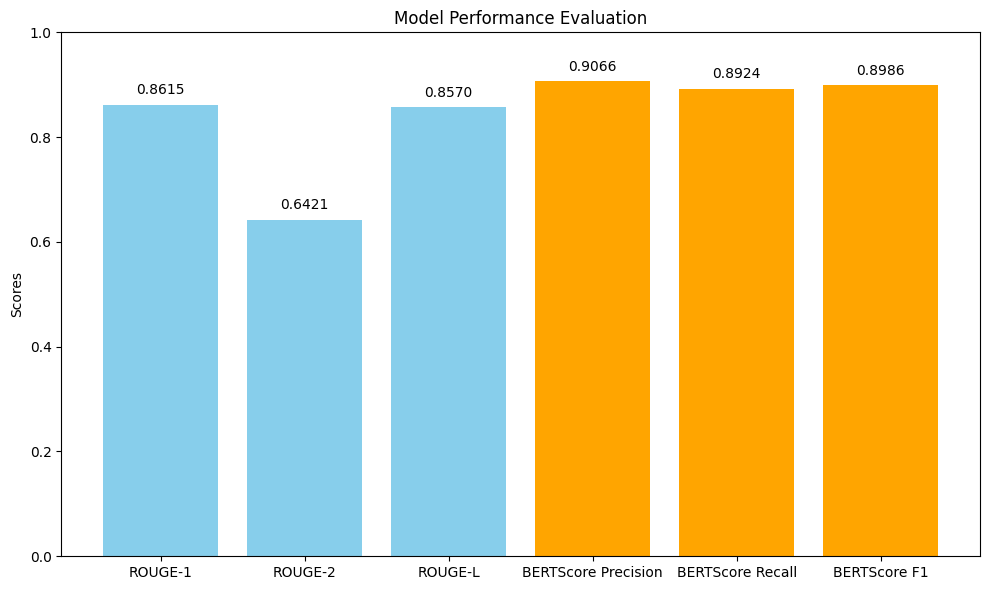

In [ ]:
def visualize_results(results):
    """
    막대 그래프로 성능 평가 결과를 시각화.

    Args:
        results (dict): 성능 평가 결과 (지표 이름과 점수)
    """
    labels = list(results.keys())
    scores = list(results.values())

    # 색상을 다르게 설정
    colors = ['skyblue' if 'ROUGE' in label else 'orange' for label in labels]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, scores, color=colors)
    plt.ylabel("Scores")
    plt.title("Model Performance Evaluation")
    plt.ylim(0, 1)  # 점수 범위 0~1 설정
    for index, value in enumerate(scores):
        plt.text(index, value + 0.02, f"{value:.4f}", ha="center")  # 막대 위에 점수 표시
    plt.tight_layout()
    plt.show()

# 막대 그래프 시각화 실행
visualize_results(results)